In [1]:
import pickle

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import seaborn as sns

from core.src.constants import IMAGES_PATH, TRAIN_DATA_CSV, TEST_DATA_CSV, FINE_TUNED_FASTVIT_MODEL_PATH, TARGET_SCALER_PATH, MODELS_PATH
from PIL import Image
import timm
from torch import nn
import pandas as pd

from core.src.utils.metrics import compute_metrics
from core.src.utils.plots import plot_loss_and_metrics, print_metrics_table

with open(TARGET_SCALER_PATH, "rb") as f:
    target_scaler = pickle.load(f)

model = timm.create_model("fastvit_t8.apple_in1k", pretrained=True, num_classes=0)

model.head = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(model.num_features, 1))

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=True)

model

FastVit(
  (stem): Sequential(
    (0): MobileOneBlock(
      (se): Identity()
      (conv_kxk): ModuleList(
        (0): ConvNormAct(
          (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Identity()
          )
        )
      )
      (conv_scale): ConvNormAct(
        (conv): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (bn): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
      )
      (act): GELU(approximate='none')
    )
    (1): MobileOneBlock(
      (se): Identity()
      (conv_kxk): ModuleList(
        (0): ConvNormAct(
          (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=48, bias=False)
          (bn): Batch

In [2]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, prices, transform=None):
        self.image_paths = image_paths
        self.prices = prices
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx])
        price = self.prices[idx]
        if self.transform:
            img = self.transform(img)
        return img, price


SLICE: int | None = None

df_train = pd.read_csv(TRAIN_DATA_CSV, dtype={"id": str})[:SLICE]
df_test = pd.read_csv(TEST_DATA_CSV, dtype={"id": str})[:SLICE]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_images = df_train["id"].values
train_images = [IMAGES_PATH / f"{path}.png" for path in train_images]

test_images = df_test["id"].values
test_images = [IMAGES_PATH / f"{path}.png" for path in test_images]

train_dataset = CustomDataset(
    image_paths=train_images,
    prices=df_train["price_std"].values,
    transform=transforms,
)

test_dataset = CustomDataset(
    image_paths=test_images,
    prices=df_test["price_std"].values,
    transform=transforms,
)

In [3]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

history = {"train_loss": [], "test_loss": []}
metrics_history = {"train_mae": [], "test_mae": [], "train_rmse": [], "test_rmse": [], "train_r2": [], "test_r2": [], "train_mse": [], "test_mse": []}

num_epochs = 10  # or more depending on convergence

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    all_train_predictions = []
    all_train_ground_truths = []
    for images, prices in tqdm(train_loader):
        images = images.to(device)
        prices = prices.to(device)

        # Forward pass
        outputs = model(images).squeeze()  # Squeeze is used to remove extra dim if any at output
        loss = criterion(outputs, prices.float())

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        unnorm_outputs = target_scaler.inverse_transform(outputs.cpu().detach().numpy().reshape(-1, 1)).reshape(-1)
        unnorm_prices = target_scaler.inverse_transform(prices.cpu().detach().numpy().reshape(-1, 1)).reshape(-1)

        all_train_predictions.extend(unnorm_outputs.tolist())
        all_train_ground_truths.extend(unnorm_prices.tolist())

    train_metrics = compute_metrics(all_train_predictions, all_train_ground_truths)
    metrics_history["train_mae"].append(train_metrics["MAE"])
    metrics_history["train_mse"].append(train_metrics["MSE"])
    metrics_history["train_rmse"].append(train_metrics["RMSE"])
    metrics_history["train_r2"].append(train_metrics["R2"])

    avg_train_loss = np.sum(train_losses) / len(train_loader)
    history["train_loss"].append(avg_train_loss)
    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}")
    print(f"Epoch {epoch + 1}, Train Metrics: {train_metrics}")

    model.eval()
    with torch.no_grad():
        validation_losses = []
        all_test_predictions = []
        all_test_ground_truths = []
        for images, prices in test_loader:
            images = images.to(device)
            prices = prices.to(device)

            # Forward pass
            outputs = model(images).squeeze()  # Squeeze is used to remove extra dim if any at output
            val_loss = criterion(outputs, prices.float())

            validation_losses.append(val_loss.item())

            unnorm_outputs = target_scaler.inverse_transform(outputs.cpu().detach().numpy().reshape(-1, 1)).reshape(-1)
            unnorm_prices = target_scaler.inverse_transform(prices.cpu().detach().numpy().reshape(-1, 1)).reshape(-1)

            all_test_predictions.extend(unnorm_outputs.tolist())
            all_test_ground_truths.extend(unnorm_prices.tolist())

        avg_val_loss = np.sum(validation_losses) / len(test_loader)
        history["test_loss"].append(avg_val_loss)

        test_metrics = compute_metrics(all_test_predictions, all_test_ground_truths)
        metrics_history["test_mae"].append(test_metrics["MAE"])
        metrics_history["test_mse"].append(test_metrics["MSE"])
        metrics_history["test_rmse"].append(test_metrics["RMSE"])
        metrics_history["test_r2"].append(test_metrics["R2"])

        print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss}")
        print(f"Epoch {epoch + 1}, Test Metrics: {test_metrics}")

    torch.save(model.state_dict(), MODELS_PATH / f"fine_tuned_fastvit_model_{epoch+1}.pth")

100%|██████████| 795/795 [05:05<00:00,  2.61it/s]


Epoch 1, Train Loss: 0.8492577667131364
Epoch 1, Train Metrics: {'MAE': 6384.645853739607, 'MSE': 67440674.2706903, 'RMSE': 8212.22712001381, 'R2': 0.14708350937394588}
Epoch 1, Validation Loss: 0.6854877997582881
Epoch 1, Test Metrics: {'MAE': 5629.541143677833, 'MSE': 54468380.80613814, 'RMSE': 7380.269697384923, 'R2': 0.3119668876279371}


100%|██████████| 795/795 [05:01<00:00,  2.64it/s]


Epoch 2, Train Loss: 0.609450707982921
Epoch 2, Train Metrics: {'MAE': 5352.85682333749, 'MSE': 48414599.5002562, 'RMSE': 6958.060038563637, 'R2': 0.3877046641751827}
Epoch 2, Validation Loss: 0.5607361703661818
Epoch 2, Test Metrics: {'MAE': 4999.5572697337575, 'MSE': 44536196.11740487, 'RMSE': 6673.544494300227, 'R2': 0.43742815236362775}


100%|██████████| 795/795 [05:28<00:00,  2.42it/s]


Epoch 3, Train Loss: 0.5283477646749725
Epoch 3, Train Metrics: {'MAE': 4910.449439705567, 'MSE': 41943637.6470889, 'RMSE': 6476.390788632886, 'R2': 0.4695423701955266}
Epoch 3, Validation Loss: 0.49405375242832317
Epoch 3, Test Metrics: {'MAE': 4670.751368566456, 'MSE': 39256523.82394091, 'RMSE': 6265.502679270108, 'R2': 0.5041198605916642}


100%|██████████| 795/795 [04:51<00:00,  2.72it/s]


Epoch 4, Train Loss: 0.48314176914077134
Epoch 4, Train Metrics: {'MAE': 4654.108995328382, 'MSE': 38360716.38505125, 'RMSE': 6193.602859810375, 'R2': 0.5148552716760317}
Epoch 4, Validation Loss: 0.4701140063192377
Epoch 4, Test Metrics: {'MAE': 4631.856463111219, 'MSE': 37365613.48573608, 'RMSE': 6112.741895887318, 'R2': 0.5280054416564307}


100%|██████████| 795/795 [04:33<00:00,  2.90it/s]


Epoch 5, Train Loss: 0.45345985358990964
Epoch 5, Train Metrics: {'MAE': 4479.49426159676, 'MSE': 36009371.78068231, 'RMSE': 6000.780930902436, 'R2': 0.5445925275664647}
Epoch 5, Validation Loss: 0.4533892115905656
Epoch 5, Test Metrics: {'MAE': 4399.222890296922, 'MSE': 36043683.66703671, 'RMSE': 6003.639201937164, 'R2': 0.5447037806567092}


100%|██████████| 795/795 [04:32<00:00,  2.91it/s]


Epoch 6, Train Loss: 0.4402199249410029
Epoch 6, Train Metrics: {'MAE': 4388.80195896628, 'MSE': 34970471.29866039, 'RMSE': 5913.583625743395, 'R2': 0.5577314138960896}
Epoch 6, Validation Loss: 0.42594092298093156
Epoch 6, Test Metrics: {'MAE': 4324.881019160161, 'MSE': 33856399.73421181, 'RMSE': 5818.625244352123, 'R2': 0.5723330905364943}


100%|██████████| 795/795 [04:33<00:00,  2.91it/s]


Epoch 7, Train Loss: 0.42264790191965285
Epoch 7, Train Metrics: {'MAE': 4279.93919182634, 'MSE': 33574350.03406203, 'RMSE': 5794.337756298129, 'R2': 0.5753880411817268}
Epoch 7, Validation Loss: 0.40990029028312647
Epoch 7, Test Metrics: {'MAE': 4209.335543964403, 'MSE': 32586292.44505039, 'RMSE': 5708.440456468858, 'R2': 0.588376818260262}


100%|██████████| 795/795 [04:33<00:00,  2.91it/s]


Epoch 8, Train Loss: 0.40621449653082675
Epoch 8, Train Metrics: {'MAE': 4192.826272766855, 'MSE': 32267502.332642768, 'RMSE': 5680.4491312433, 'R2': 0.5919156332814646}
Epoch 8, Validation Loss: 0.4004060128076592
Epoch 8, Test Metrics: {'MAE': 4147.236191996244, 'MSE': 31833466.766128473, 'RMSE': 5642.115451329269, 'R2': 0.5978863536508181}


100%|██████████| 795/795 [04:56<00:00,  2.68it/s]


Epoch 9, Train Loss: 0.3954213836283054
Epoch 9, Train Metrics: {'MAE': 4136.707421536356, 'MSE': 31416722.48305526, 'RMSE': 5605.062219374131, 'R2': 0.6026753739194803}
Epoch 9, Validation Loss: 0.3802090457186627
Epoch 9, Test Metrics: {'MAE': 4057.0173823967, 'MSE': 30203915.557094123, 'RMSE': 5495.808908349536, 'R2': 0.6184705012521952}


100%|██████████| 795/795 [05:17<00:00,  2.50it/s]


Epoch 10, Train Loss: 0.3747071130283224
Epoch 10, Train Metrics: {'MAE': 4007.2708385451924, 'MSE': 29744897.78397971, 'RMSE': 5453.88831788658, 'R2': 0.623818799169859}
Epoch 10, Validation Loss: 0.38011193125691245
Epoch 10, Test Metrics: {'MAE': 4051.3289759103573, 'MSE': 30225196.68784032, 'RMSE': 5497.744691038346, 'R2': 0.6182016824915602}


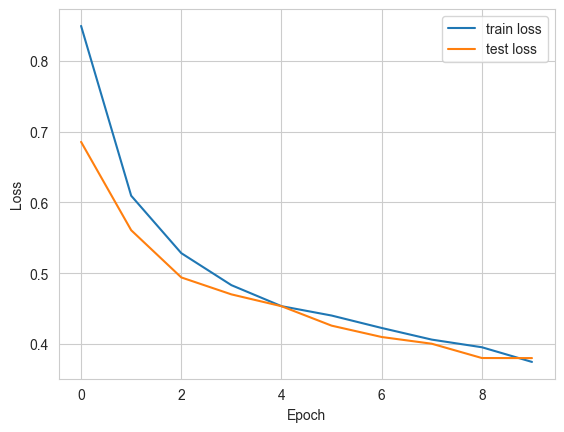

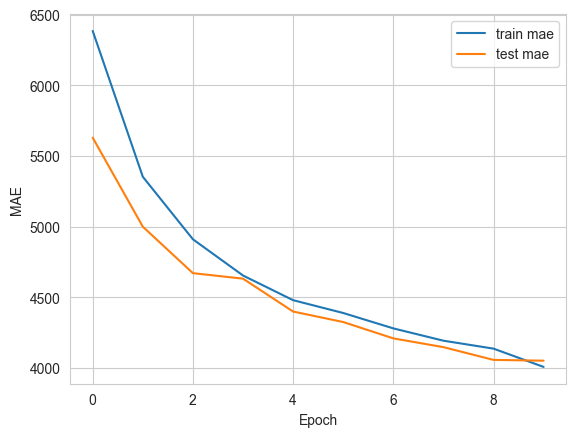

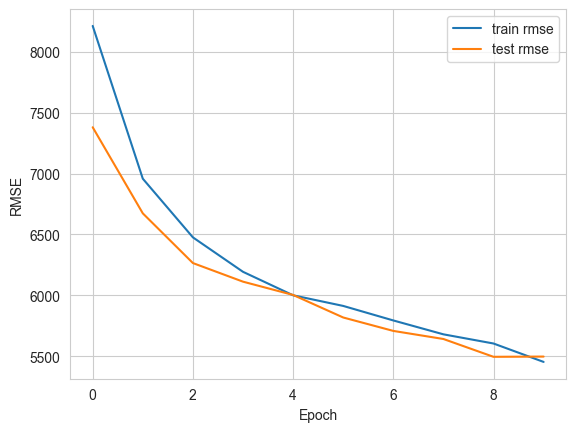

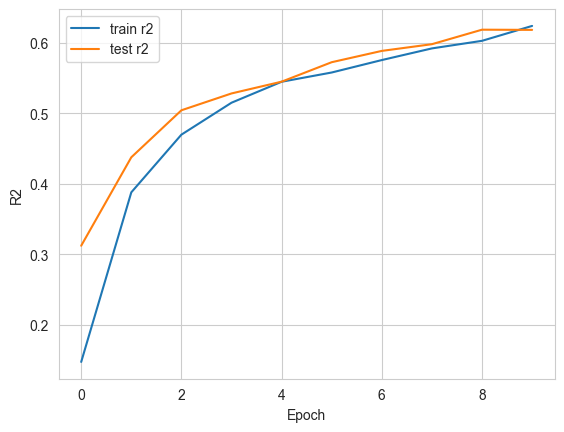

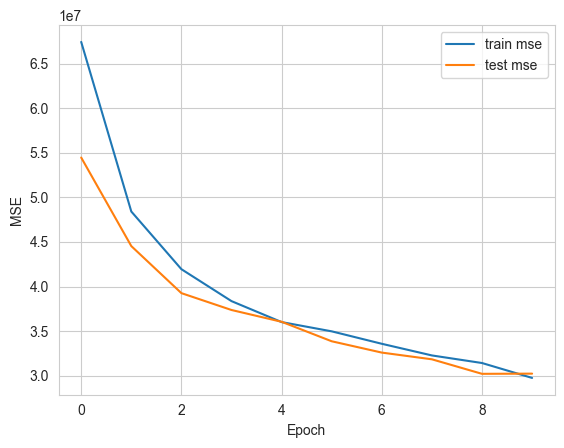

Train Metrics
+---------+---------+---------+---------+-------------+
|   Epoch |     MAE |    RMSE |      R2 |         MSE |
+=========+=========+=========+=========+=============+
|       9 | 4007.27 | 5453.89 | 0.62382 | 2.97449e+07 |
+---------+---------+---------+---------+-------------+

Test Metrics
+---------+---------+---------+--------+-------------+
|   Epoch |     MAE |    RMSE |     R2 |         MSE |
+=========+=========+=========+========+=============+
|       9 | 4051.33 | 5497.74 | 0.6182 | 3.02252e+07 |
+---------+---------+---------+--------+-------------+


In [5]:
plot_loss_and_metrics(history, metrics_history, SLICE_START=0)
print_metrics_table(metrics_history)

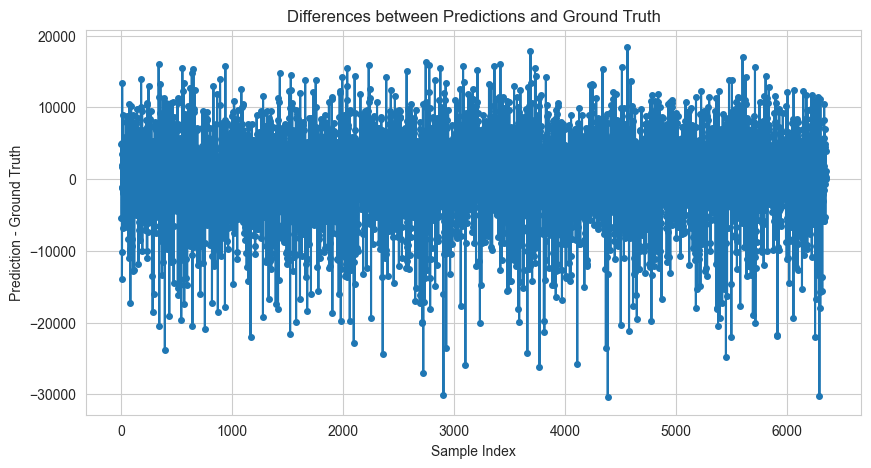

Average absolute difference: 4043.63


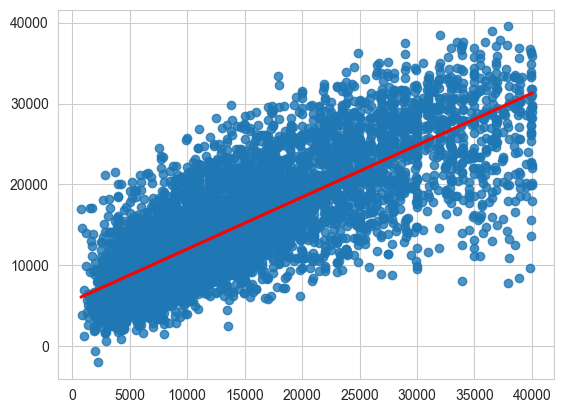

In [6]:
differences = []
abs_differences = []
gt = []
pred = []

with torch.no_grad():
    for images, prices in test_loader:
        images = images.to(device)
        prices = prices.to(device)
        outputs = model(images).squeeze()

        prices = prices.cpu().numpy()
        outputs = outputs.cpu().numpy()

        unnorm_outputs = target_scaler.inverse_transform(outputs.reshape(-1, 1)).reshape(-1)
        unnorm_prices = target_scaler.inverse_transform(prices.reshape(-1, 1)).reshape(-1)

        for output, target in zip(unnorm_outputs, unnorm_prices):
            diff = output - target
            differences.append(diff)
            abs_differences.append(abs(diff))
            gt.append(target)
            pred.append(output)

# Plotting the differences
plt.figure(figsize=(10, 5))
plt.plot(differences, marker="o", linestyle="-", markersize=4)
plt.title("Differences between Predictions and Ground Truth")
plt.xlabel("Sample Index")
plt.ylabel("Prediction - Ground Truth")
plt.grid(True)
plt.show()

sns.regplot(x=gt, y=pred, ci=None, scatter=True, line_kws={"color": "red"})

# calculate the average difference
average_abs_diff = sum(abs_differences) / len(abs_differences)
print(f"Average absolute difference: {average_abs_diff:.2f}")

In [7]:
torch.save(model.state_dict(), f=FINE_TUNED_FASTVIT_MODEL_PATH)

# Inference example

In [8]:
# model = timm.create_model("fastvit_t8.apple_in1k", pretrained=True, num_classes=0)
#
# model.head = nn.Sequential(
#     nn.AdaptiveAvgPool2d(1),
#     nn.Flatten(),
#     nn.Linear(model.num_features, 1)
# )
#
# model.load_state_dict(torch.load(FINE_TUNED_FASTVIT_MODEL_PATH))
# model.to(device)
#
# model
#
#
# class FastViTEmbedding(nn.Module):
#     def __init__(self, model):
#         super(FastViTEmbedding, self).__init__()
#         self.model = model
#         self.pool = nn.AdaptiveAvgPool2d(1)
#
#     def forward(self, x):
#         # Assuming the embeddings you want are just before the head.
#         # This accesses the last layer before the regression head.
#         x = self.model.forward_features(x)
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         return x
#
#
# embedding_model = FastViTEmbedding(model).to(device)
# embedding_model.eval()
#
# with torch.no_grad():
#     for images, _ in test_loader:  # Ignore prices if you just need embeddings
#         images = images.to(device)
#         embeddings = embedding_model(images)
#         print("Embedding shape:", embeddings.shape)